In [1]:
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
####################you will need to change some paths here!#####################
#list of input files
dir_in='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_mur = 'F:/data/sst/jpl_mur/v4.1/'
#output files
#filename_out_nc='F:/data/cruise_data/saildrone/baja-2018/daily_files/sd-1002/data_so_far.nc'
#filename_out_kml='F:/data/cruise_data/saildrone/baja-2018/daily_files/sd-1002/data_so_far.kml'
#################################################################################
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib as mpl
#import openpyxl
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import math
#from math import cos, radians

In [2]:
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    lonmin=180
    lonmax=-180
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        #print(fname_in[31:35],fname_in[36:39])
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        #print(iyr_storm,inum_storm)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat
        lons = dsx.lon
        if lonmin>min(lons[0,:].values):
            lonmin=min(lons[0,:].values)
        if lonmax<max(lons[0,:].values):
            lonmax=max(lons[0,:].values)
    print(iyr_storm,lonmin,lonmax)
print(type(lons))

2002 47.19999894499779 328.80000069737434
2003 29.39999934285879 354.00000013411045
2004 2.4999999441206455 358.0000000447035
2005 0.0 359.00000002235174
2006 38.199999146163464 357.0000000670552
2007 32.899999264627695 353.0000001564622
2008 37.59999915957451 338.10000048950315
2009 33.599999248981476 352.3000001721084
2010 35.09999921545386 345.50000032410026
2011 0.0 353.0000001564622
2012 28.399999365210533 352.50000016763806
2013 37.899999152868986 342.9000003822148
2014 34.19999923557043 345.0000003352761
2015 37.59999915957451 352.3000001721084
2016 43.399999029934406 341.0000004246831
2017 103.09999769553542 153.99999655783176
2017 180 -180
<class 'xarray.core.dataarray.DataArray'>


In [3]:
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
    for ii in range(32,33): 
#    for name in files:
        name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        if iyr_storm!=2004:
            continue
        if iyr_storm==2004:
            print(iyr_storm,inum_storm)
        print(name,fname_in)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat[0,:]
        lons = dsx.lon[0,:]  #lons goes from 0 to 360
        dysince = dsx.time
        #minlon=min(lons[0,:].values)-10
        #maxlon=max(lons[0,:].values)+10
        #minlat=min(lats[0,:].values)-10
        #maxlat=max(lats[0,:].values)+10
        
        iwrap=0
        minlon=min(lons.values)-10
        maxlon=max(lons.values)+10
        minlat=min(lats.values)-10
        maxlat=max(lats.values)+10
        if minlon<10 and maxlon>350:  #wrapping around meridion need to cal new min/max lon
            minlon=max(lons[lons<180].values)+10
            maxlon=min(lons[lons>180].values)-10
            iwrap=1 #set flag for wraparound
        print(minlon,maxlon,minlat,maxlat)
        print('min/max lon lat',minlon,maxlon,minlat,maxlat)

        ix1=int(round((minlon-dx_offset)/dx))
        ix2=int(round((maxlon-dx_offset)/dx))
        iy1=int(round((minlat-dy_offset)/dy))
        iy2=int(round((maxlat-dy_offset)/dy))
        if iy2 > 628:
            iy2=628
        if iy1 < 1:
            iy1=1    
        if ix1 < 0:
            ix1 = ix1 + 1440
        if ix2 < 0:
            ix2 = ix2 + 1440
        #if ix1 > 1440:
        #    ix1 = ix1 - 1440
        #if ix2 > 1440:
        #    ix2 = ix2 - 1440
        print(minlon,maxlon,minlat,maxlat)
        xdim=ix2-ix1
        if iwrap==1:  #wraps around so make sure xdim reflects that
            xdim=ix1-ix2+1440

        ydim=iy2-iy1
        
        print('ix',ix1,ix2,xdim)
        print('iy',iy1,iy2,ydim)
        
        dims=lats.shape
        tdim=dims[0]
#        tdim=dims[1]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        minjdy = min(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min(tem_date).year #create new time array that can be queried for year etc
        maxjdy = max(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        maxyear =max(tem_date).year  #create new time array that can be queried for year etc
        print(minyear,minjdy,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+30

        print(tdim,ix1,ix2,iy1,iy2,xdim,ydim)      
        
        #if xdim>720:
            #ix1=int(round((minlon+dx_offset)/dx))+1441 #for when wraps 180 to -180
            #ix2=int(round((maxlon+dx_offset)/dx))
            #xdim=abs(xdim-1440)
        #    xdim=ix1-ix2+1440
        #    print('xdim wrapped:',xdim,ix1,ix2)
        
        
        #print('min/max lon lat ARRAY',lons(ix1),lons(ix2))
        


 

2004 38
038annual_storm_info.nc f:/data/tc_wakes/database/info/2004\038annual_storm_info.nc
221.60000286996365 264.50000235810876 4.59999967366457 36.899999398738146
min/max lon lat 221.60000286996365 264.50000235810876 4.59999967366457 36.899999398738146
221.60000286996365 264.50000235810876 4.59999967366457 36.899999398738146
ix 1606 1778 172
iy 332 461 129
2004 194 2004 201
36 1606 1778 332 461 172 129


IndexError: list index out of range

In [4]:
i=0
storm_date = tem_date[0]+dt.timedelta(days=i)
            #print(storm_date)
            
syr=str(storm_date.year)
smon=str(storm_date.month)
sdym=str(storm_date.day)
sjdy=str(storm_date.timetuple().tm_yday)
fname_tem=syr + smon.zfill(2) + sdym.zfill(2) + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
mur_filename = dir_mur + syr + '/' + sjdy.zfill(3) + '/' + fname_tem
start_time = time.clock()
lon_grid = np.zeros(xdim)
for j in range(0,xdim):
    lon_grid[j]=(j+ix1)*dx+dx_offset
    if lon_grid[j]>180:
        lon_grid[j]=lon_grid[j]-360
lat_grid = np.zeros(ydim)
for j in range(0,ydim):
    lat_grid[j]=(j+iy1)*dy+dy_offset
print(mur_filename)
ds_mur = xr.open_dataset(mur_filename,drop_variables=['analysis_error','mask','sea_ice_fraction'])
ds_subset = ds_mur.interp(lon=lon_grid, lat=lat_grid)
end_time = time.clock()
print(end_time-start_time)
print(ds_subset)

C:\Users\gentemann\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


F:/data/sst/jpl_mur/v4.1/2004/194/20040712090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
17.775270981999995
<xarray.Dataset>
Dimensions:       (lat: 129, lon: 172, time: 1)
Coordinates:
  * time          (time) datetime64[ns] 2004-07-12T09:00:00
  * lon           (lon) float64 -138.4 -138.1 -137.9 ... -96.12 -95.88 -95.62
  * lat           (lat) float64 4.625 4.875 5.125 5.375 ... 36.12 36.38 36.62
Data variables:
    analysed_sst  (time, lat, lon) float64 301.7 301.5 301.7 ... nan nan nan
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    license: 

C:\Users\gentemann\Miniconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


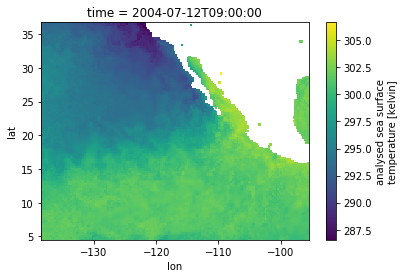

In [5]:
ds_subset.analysed_sst.plot()

In [6]:
ilat_mur1 = np.argmin(abs(mlat-minlat))
ilat_mur2 = np.argmin(abs(mlat-maxlat))
print(ilat_mur1,ilat_mur2)

NameError: name 'mlat' is not defined

In [17]:
from math import ceil 
for i in range(0,1):
    for j in range(0,1):
            start_time = time.clock()
            print(mur_filename)
            nc_fid = Dataset(mur_filename, 'r')
            mlat = nc_fid.variables['lat'][1149:16849]
            minlat_tem = minlat+
            ilat_mur1 = np.argmin(abs(mlat-minlat))-100
            tem_lat_mur = mlat[ilat_mur1]   #make sure it is on .25 grid
            ilat_mur2 = np.argmin(abs(mlat-maxlat))+100
            print('lat:', mlat[ilat_mur2],maxlat)
            int_25=math.ceil((ilat_mur2-ilat_mur1)/25)
            ilat_mur2=ilat_mur1+25*int_25
            print('lat:', mlat[ilat_mur2],maxlat)
            print(ilat_mur1,ilat_mur2)
            #mlat = nc_fid.variables['lat'][ilat_mur1:ilat_mur2]
            mlat = mlat[ilat_mur1:ilat_mur2]
            sst = nc_fid.variables['analysed_sst'][0,ilat_mur1:ilat_mur2,:]
            mlon = nc_fid.variables['lon'][:]
            nc_fid.close()
            coarseness = 25  #this code resamples all data into 25 km cells then takes the mean of all that data 
            temp = mlon.reshape((mlon.shape[0] // coarseness, coarseness))
            coarse_mlon = np.mean(temp, axis=(1), dtype=np.float64)
            temp = mlat.reshape((mlat.shape[0] // coarseness, coarseness))
            coarse_mlat = np.mean(temp, axis=(1), dtype=np.float64)
            temp = sst.reshape((sst.shape[0] // coarseness, coarseness, sst.shape[1] // coarseness, coarseness))
            coarse_sst = np.mean(temp, axis=(1,3), dtype=np.float64)
            
            #need to recalculate iy1 and iy2 because of offset made earlier to read less of file
            iy1=np.argmin(abs(coarse_mlat-minlat))
            iy2=np.argmin(abs(coarse_mlat-maxlat))
            ydim=iy2-iy1   
            print(coarse_mlat[0],coarse_mlat[-1])
            print(iy1,iy2,ydim,minlat,maxlat)
            
            if i==0:
                print('i=0',iy1,iy2,ix1,ix2,iy2-iy1,ix2-ix1)
            if ix1<=1440 and ix2<=1440 and iwrap==0:
                if i==0:
                    print('inside1',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1:ix2]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1:ix2]
            if ix1>1440 and ix2>1440 and iwrap==0:
                if i==0:
                    print('inside2',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1-1440:ix2-1440]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1-1440:ix2-1440]
            if ix1<=1440 and ix2>1440 and iwrap==0:
                if i==0:
                    print('inside3',iy1,iy2,ix1,ix2)
                tem1 = coarse_sst[iy1:iy2,ix1:]
                tem2 = coarse_sst[iy1:iy2,:ix2-1440]
                sst_out = np.append(tem1,tem2, axis=1)
                mlat_out = coarse_mlat[iy1:iy2]
                mlon1 = coarse_mlon[ix1:]
                mlon2 = coarse_mlon[:ix2-1440]
                print(mlon1.shape,mlon2.shape)
                mlon_out = np.append(mlon1,mlon2, axis=0)               

            if ix1<=1440 and ix2>1440 and iwrap==1:
                if i==0:
                    print('inside1',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix2-1440:ix1]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix2-1440:ix1]

end_time = time.clock()
print(end_time-start_time)

C:\Users\gentemann\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


F:/data/sst/jpl_mur/v4.1/2004/194/20040712090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
lat: 37.9 36.899999398738146
lat: 38.1 36.899999398738146
8210 11660
3.72 37.97
4 133 129 4.59999967366457 36.899999398738146
i=0 4 133 1606 1778 129 172
inside2 4 133 1606 1778
4.255711917999633


C:\Users\gentemann\Miniconda3\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [18]:
sst_out.shape
#coarse_sst.shape
#ds_mur.lon

(129, 172)

In [ ]:
for i in range(0,10):
#    print(mlon_out[i],ds_subset.lon.data[i])
#    print(mlat_out[i],ds_subset.lat.data[i])
    print(sst_out[i,0],ds_subset.analysed_sst.data[0,i,0])

In [ ]:
diff=sst_out-ds_subset.analysed_sst[0,:,:]

In [ ]:
diff

In [ ]:
###### dir_mur = 'F:/data/sst/jpl_mur/v4.1/'
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        if iyr_storm>2003 or iyr_storm<2003:
            continue
#        if iyr_storm==2011 and inum_storm<15:
#            continue
        print(name,fname_in)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat[0,:]
        lons = dsx.lon[0,:]  #lons goes from 0 to 360
        dysince = dsx.time
        #minlon=min(lons[0,:].values)-10
        #maxlon=max(lons[0,:].values)+10
        #minlat=min(lats[0,:].values)-10
        #maxlat=max(lats[0,:].values)+10
        
        iwrap=0
        minlon=min(lons.values)-10
        maxlon=max(lons.values)+10
        minlat=min(lats.values)-10
        maxlat=max(lats.values)+10
        if minlon<10 and maxlon>350:  #wrapping around meridion need to cal new min/max lon
            minlon=max(lons[lons<180].values)+10
            maxlon=min(lons[lons>180].values)-10
            iwrap=1 #set flag for wraparound
        
        
        
        #here is a fix for when a storm goes from 350 across 360 to 1 2 longitude
#        iwrap=0
#        print('first and last!',lons[0,1].values,lons[0,-1].values)
#        if abs(min(lons[0,:].values)-max(lons[0,:].values))>180:
#            lons1=lons[0,:].values-10>180
#            lons2=lons[0,:].values+10<180
#            maxlon=min(lons[0,lons1].values-10)
#            minlon=max(lons[0,lons2].values+10)
#            print('wrapped',minlon,maxlon)
#            iwrap=1
            #wrap_lons = ((lons+180) % 360) - 180        
            #maxlon=max(wrap_lons[0,:].values)+10 #this will find the positive maximum
            #minlon=min(wrap_lons[0,:].values)-10
            #if minlon<0:
            #    maxlon=min(wrap_lons[0,:].values)-10+360
            #    minlon=max(wrap_lons[0,:].values)+10

        print('min/max lon lat',minlon,maxlon,minlat,maxlat)

        ix1=int(round((minlon-dx_offset)/dx))
        ix2=int(round((maxlon-dx_offset)/dx))
        iy1=int(round((minlat-dy_offset)/dy))
        iy2=int(round((maxlat-dy_offset)/dy))
        if iy2 > 628:
            iy2=628
        if iy1 < 1:
            iy1=1    
        if ix1 < 0:
            ix1 = ix1 + 1440
        if ix2 < 0:
            ix2 = ix2 + 1440
        #if ix1 > 1440:
        #    ix1 = ix1 - 1440
        #if ix2 > 1440:
        #    ix2 = ix2 - 1440
        print(minlon,maxlon,minlat,maxlat)
        xdim=ix2-ix1
        if iwrap==1:  #wraps around so make sure xdim reflects that
            xdim=ix1-ix2+1440

        ydim=iy2-iy1
        
        dims=lats.shape
        tdim=dims[0]
#        tdim=dims[1]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        minjdy = min(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min(tem_date).year #create new time array that can be queried for year etc
        maxjdy = max(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        maxyear =max(tem_date).year  #create new time array that can be queried for year etc
        print(minyear,minjdy,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+30

        #need to think about how it wraps around before putting in
        #box add a mask that removes all data except that near storm
        #storm_mask = np.ones([628,1440], dtype=bool)
        #for i in range(0,tdim):
        #    float(lats[0,i].values)
        #    lat1 = int(round((float(lats[0,i].values)-10-dy_offset)/dy))
        #    lon1 = int(round((float(lons[0,i].values)-10-dx_offset)/dx))
        #    lat2 = int(round((float(lats[0,i].values)+10-dy_offset)/dy))+1
        #    lon2 = int(round((float(lons[0,i].values)+10-dx_offset)/dx))+1 #python index goes from index1 up to but not including index2
        #    if lat2>628:
        #        lat2=628
        #    if lat1<0:
        #        lat1=0
        #    if lon1>=0 and lon2<=1440:
        #        storm_mask[lat1:lat2,lon1:lon2]=bool(0)
        #    if lon1<0 and lon2<=1440:
        #        storm_mask[lat1:lat2,:lon2]=1.
        #        storm_mask[lat1:lat2,lon1+1440:]=bool(0)
        #    if lon1>=0 and lon2>1440:
        #        storm_mask[lat1:lat2,lon1:]=1.
        #        storm_mask[lat1:lat2,:lon2-1440:]=bool(0)              

        print(tdim,ix1,ix2,iy1,iy2,xdim,ydim)      
        
        #if xdim>720:
            #ix1=int(round((minlon+dx_offset)/dx))+1441 #for when wraps 180 to -180
            #ix2=int(round((maxlon+dx_offset)/dx))
            #xdim=abs(xdim-1440)
        #    xdim=ix1-ix2+1440
        #    print('xdim wrapped:',xdim,ix1,ix2)
        
        
        #print('min/max lon lat ARRAY',lons(ix1),lons(ix2))
        
        sst_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        sst_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndu_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndv_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndu_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndv_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        
        print('sst_out_sv',sst_out_sv.shape)
        for i in range(0,tdim):
            storm_date = tem_date[0]+dt.timedelta(days=i)
            #print(storm_date)
            
            syr=str(storm_date.year)
            smon=str(storm_date.month)
            sdym=str(storm_date.day)
            sjdy=str(storm_date.timetuple().tm_yday)
            fname_tem=syr + smon.zfill(2) + sdym.zfill(2) + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
            mur_filename = dir_mur + syr + '/' + sjdy.zfill(3) + '/' + fname_tem
            fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
            ccmp_filename = dir_ccmp + syr + '/M' + smon.zfill(2) + fname_tem      

            if storm_date.timetuple().tm_yday==366:
                sjdy = '365'
            clim_filename='F:/data/sst/jpl_mur/v4.1/clim/clim2_' + sjdy.zfill(3) +'_2003_2013_MUR-GLOB-v02.0-fv04.1.nc'
            ccmp_clim_filename='F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_' + sjdy.zfill(3) +'.nc'
            print(ccmp_filename)
            print(ccmp_clim_filename)

#            nc_fid3 = Dataset(ccmp_filename, 'r')
#            nc_fid4 = Dataset(ccmp_clim_filename, 'r')          
            
            nc_fid = Dataset(mur_filename, 'r')
            sst = nc_fid.variables['analysed_sst'][0,1149:16849,:]
            mlat = nc_fid.variables['lat'][1149:16849]
            mlon = nc_fid.variables['lon'][:]
            nc_fid.close()

            coarseness = 25
            temp = mlon.reshape((mlon.shape[0] // coarseness, coarseness))
            coarse_mlon = np.mean(temp, axis=(1), dtype=np.float64)
            temp = mlat.reshape((mlat.shape[0] // coarseness, coarseness))
            coarse_mlat = np.mean(temp, axis=(1), dtype=np.float64)
            temp = sst.reshape((sst.shape[0] // coarseness, coarseness, sst.shape[1] // coarseness, coarseness))
            coarse_sst = np.mean(temp, axis=(1,3), dtype=np.float64)
            
            nc_fid2 = Dataset(clim_filename, 'r')                      
            sst_clim = nc_fid2.variables['sst'][1149:16849,:]
            nc_fid2.close()
            
            temp = sst_clim.reshape((sst_clim.shape[0] // coarseness, coarseness, sst_clim.shape[1] // coarseness, coarseness))
            coarse_sst_clim = np.mean(temp, axis=(1,3), dtype=np.float64)
 
            nc_fid = Dataset(ccmp_filename, 'r')
            nc_fid2 = Dataset(ccmp_clim_filename, 'r')  
            tem = nc_fid.variables['uwnd'][:]
            tem = np.mean(tem,axis=0)
            wndu = np.append(tem[:,720:],tem[:,:720], axis=1)               
            tem = nc_fid.variables['vwnd'][:]
            tem = np.mean(tem,axis=0)
            wndv = np.append(tem[:,720:],tem[:,:720], axis=1)               
            mlat_ccmp = nc_fid.variables['latitude'][:]
            tem = nc_fid.variables['longitude'][:]
            mlon_ccmp = np.append(tem[720:],tem[:720], axis=0)               
            mlon_ccmp = ((mlon_ccmp - 180) % 360) - 180  #make -180 to 180 rather than 0 360
            tem = nc_fid2.variables['av_u'][:]
            wndu_clim = np.append(tem[:,720:],tem[:,:720], axis=1)               
            tem = nc_fid2.variables['av_v'][:]
            wndv_clim = np.append(tem[:,720:],tem[:,:720], axis=1)               
            nc_fid.close()
            nc_fid2.close()
            
            #data_mask = coarse_sst.mask
            #data_mask[storm_mask==bool(1)]=bool(1)
            #coarse_sst.mask = data_mask
            #coarse_sst_clim.mask = data_mask         
            
            if i==0:
                print('i=0',iy1,iy2,ix1,ix2,iy2-iy1,ix2-ix1)
            if ix1<=1440 and ix2<=1440 and iwrap==0:
                if i==0:
                    print('inside1',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1:ix2]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1:ix2]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix1:ix2]
                wndu_out = wndu[iy1:iy2,ix1:ix2]
                wndu_clim_out = wndu_clim[iy1:iy2,ix1:ix2]
                wndv_out = wndv[iy1:iy2,ix1:ix2]
                wndv_clim_out = wndv_clim[iy1:iy2,ix1:ix2]
            if ix1>1440 and ix2>1440 and iwrap==0:
                if i==0:
                    print('inside2',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1-1440:ix2-1440]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1-1440:ix2-1440]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix1-1440:ix2-1440]
                wndu_out = wndu[iy1:iy2,ix1-1440:ix2-1440]
                wndu_clim_out = wndu_clim[iy1:iy2,ix1-1440:ix2-1440]
                wndv_out = wndv[iy1:iy2,ix1-1440:ix2-1440]
                wndv_clim_out = wndv_clim[iy1:iy2,ix1-1440:ix2-1440]
            if ix1<=1440 and ix2>1440 and iwrap==0:
                if i==0:
                    print('inside3',iy1,iy2,ix1,ix2)
                tem1 = coarse_sst[iy1:iy2,ix1:]
                tem2 = coarse_sst[iy1:iy2,:ix2-1440]
                sst_out = np.append(tem1,tem2, axis=1)
                mlat_out = coarse_mlat[iy1:iy2]
                mlon1 = coarse_mlon[ix1:]
                mlon2 = coarse_mlon[:ix2-1440]
                print(mlon1.shape,mlon2.shape)
                mlon_out = np.append(mlon1,mlon2, axis=0)               
                tem1 = coarse_sst_clim[iy1:iy2,ix1:]
                tem2 = coarse_sst_clim[iy1:iy2,:ix2-1440]
                sst_clim_out = np.append(tem1,tem2, axis=1)

                tem1 = wndu[iy1:iy2,ix1:]
                tem2 = wndu[iy1:iy2,:ix2-1440]
                wndu_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv[iy1:iy2,ix1:]
                tem2 = wndv[iy1:iy2,:ix2-1440]
                wndv_out = np.append(tem1,tem2, axis=1)
                tem1 = wndu_clim[iy1:iy2,ix1:]
                tem2 = wndu_clim[iy1:iy2,:ix2-1440]
                wndu_clim_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv_clim[iy1:iy2,ix1:]
                tem2 = wndv_clim[iy1:iy2,:ix2-1440]
                wndv_clim_out = np.append(tem1,tem2, axis=1)

            if ix1<=1440 and ix2>1440 and iwrap==1:
                if i==0:
                    print('inside1',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix2-1440:ix1]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix2-1440:ix1]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix2-1440:ix1]
                wndu_out = wndu[iy1:iy2,ix2-1440:ix1]
                wndu_clim_out = wndu_clim[iy1:iy2,ix2-1440:ix1]
                wndv_out = wndv[iy1:iy2,ix2-1440:ix1]
                wndv_clim_out = wndv_clim[iy1:iy2,ix2-1440:ix1]

            if i==0:
                print('sst',sst_out.shape,'sst_sv',sst_out_sv.shape)
                print('mlon',mlon_out.shape,'mlat',mlat_out.shape)
            #sst_sv[i,:,:]=sst-sst_clim
            sst_out_sv[i,:,:]=sst_out
            sst_clim_out_sv[i,:,:]=sst_clim_out
            wndu_out_sv[i,:,:]=wndu_out
            wndv_out_sv[i,:,:]=wndv_out
            wndu_clim_out_sv[i,:,:]=wndu_clim_out
            wndv_clim_out_sv[i,:,:]=wndv_clim_out
            
        ilen=len(fname_in)
        
        dif_dys=[0]*tdim
        for i in range(0,tdim):
            dif_dys[i] = i

        print('file out:',fname_out)
        #f.close()
        f = Dataset(fname_out,'w', format='NETCDF4') 
        tempgrp = f.createGroup('data')
        tempgrp.setncattr_string('start time',str(tem_date[0]))
        tempgrp.createDimension('t', tdim)
        tempgrp.createDimension('y', ydim)
        tempgrp.createDimension('x', xdim)

    #tem_date[i]
        sst_netcdf = tempgrp.createVariable('sst', 'f4', ('t', 'y', 'x'))
        sst_clim_netcdf = tempgrp.createVariable('sst_clim', 'f4', ('t', 'y', 'x'))
        wndu_netcdf = tempgrp.createVariable('wndu', 'f4', ('t', 'y', 'x'))
        wndv_netcdf = tempgrp.createVariable('wndv', 'f4', ('t', 'y', 'x'))
        wndu_clim_netcdf = tempgrp.createVariable('wndu_clim', 'f4', ('t', 'y', 'x'))
        wndv_clim_netcdf = tempgrp.createVariable('wndv_clim', 'f4', ('t', 'y', 'x'))
        longitude = tempgrp.createVariable('lon', 'f4', 'x')
        latitude = tempgrp.createVariable('lat', 'f4', 'y')  
        time = tempgrp.createVariable('time', 'i4', 't')
        
        sst_netcdf[:] = sst_out_sv
        sst_clim_netcdf[:] = sst_clim_out_sv
        wndu_netcdf[:] = wndu_out_sv
        wndv_netcdf[:] = wndv_out_sv
        wndu_clim_netcdf[:] = wndu_clim_out_sv
        wndv_clim_netcdf[:] = wndv_clim_out_sv
        latitude[:] = mlat_out
        longitude[:] = mlon_out
        time[:]=dif_dys
        f.close()
    


In [ ]:
dims[0]

In [ ]:
print(lons.shape)
print(lons[0,68:].shape,69-68)
print(lons[0,67:].shape,69-67)
print(lons.shape)
print(lons[0,:0].shape,0)
print(lons[0,:1].shape,1)
lons

In [ ]:
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.mlab as mlab
palette = copy(plt.cm.jet)
palette.set_over('r', 1.0)
palette.set_under('g', 1.0)
palette.set_bad(alpha = 0.0)

dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
    for ii in range(12,13): 
#    for name in files:
        name = files[ii]
#    for name in files:
        fname_tem=os.path.join(root, name)
        fname_in=dir_out + fname_tem[31:39] + '_all_25km.nc'

        #nc_fid.close()
        nc_fid = Dataset(fname_in, 'r')
        tempgrp = nc_fid.groups['data']
        #tempgrp = nc_fid.createGroup('Eddy_data')
        sst = tempgrp.variables['sst'][:]
        sst_clim = tempgrp.variables['sst_clim'][:]
        wndu = tempgrp.variables['wndu'][:]
        wndv = tempgrp.variables['wndv'][:]
        lon = tempgrp.variables['lon'][:]
        lat = tempgrp.variables['lat'][:]
        time = tempgrp.variables['time'][:]
        nc_fid.close()
        
        sst_diff = sst -273.15 - sst_clim
        print(sst.shape,sst_clim.shape)
        fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
        # plot using 'continuous' color map
        im = ax1.imshow(sst_diff[30,:,:], interpolation='bilinear',
                        cmap=palette,
                        norm=colors.Normalize(vmin=-5.0, vmax=5.0),
                        aspect='auto',
                        origin='lower')
                        #extent=[x0, x1, y0, y1])
        ax1.set_title('SST')
        cbar = fig.colorbar(im, extend='both', shrink=0.9, ax=ax1)
        cbar.set_label('SST - SST climatology')
        for ticklabel in ax1.xaxis.get_ticklabels():
            ticklabel.set_visible(False)
        plt.show()
        

In [ ]:
    
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.mlab as mlab
palette = copy(plt.cm.jet)
palette.set_over('r', 1.0)
palette.set_under('g', 1.0)
palette.set_bad(alpha = 0.0)
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
# plot using 'continuous' color map
im = ax1.imshow(coarse_sst, interpolation='bilinear',
                cmap=palette,
                norm=colors.Normalize(vmin=-2.0, vmax=32.0),
                aspect='auto',
                origin='lower')
                #extent=[x0, x1, y0, y1])
ax1.set_title('SST')
cbar = fig.colorbar(im, extend='both', shrink=0.9, ax=ax1)
cbar.set_label('uniform')
for ticklabel in ax1.xaxis.get_ticklabels():
    ticklabel.set_visible(False)
plt.show()

In [ ]:
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y' 
fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
ccmp_filename = dir_ccmp + syr + '/M' + smon + fname_tem      
#ccmp_clim_filename='F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_' + sjdy.zfill(3) +'.nc'
print(ccmp_filename)
nc_fid = Dataset(ccmp_filename, 'r')
tem = nc_fid.variables['uwnd'][:]
tem2 = np.append(tem[:,721:],tem[:,:721], axis=1)               
nc_fid.close()
print(tem.shape)
print(tem2.shape)

In [ ]:
nc_fid3.close()
nc_fid4.close()


In [ ]:
sst_out[1:5,1:5]

In [ ]:

dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        if iyr_storm<2005:
            continue
        if iyr_storm==2005 and inum_storm<70:
            continue
        print(name,fname_in)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat
        lons = dsx.lon
        dysince = dsx.time
        len_lons = lons.shape
        minlon=min(lons[0,:].values)-10
        maxlon=max(lons[0,:].values)+10
        minlat=min(lats[0,:].values)-10
        maxlat=max(lats[0,:].values)+10
        #here is a fix for when a storm goes from 350 across 360 to 1 2 longitude
        if lons[0,1].values>180 and lons[0,-1].values<180:
            wrap_lons = ((lons+180) % 360) - 180        
            minlon=min(wrap_lons[0,:].values)-10
            maxlon=max(wrap_lons[0,:].values)+10
        if minlon<0:
            minlon=minlon+360
        if maxlon>360:
            maxlon=maxlon-360
        print(minlon,maxlon,minlat,maxlat)
        print(lons)
        #print(wrap_lons)
        break



In [ ]:
print(lons[0,1].values,lons[0,len_lon[1]].values)
lons

In [ ]:
 
minlon=10
maxlon=293
ix1=int(round((minlon-dx_offset)/dx))
ix2=int(round((maxlon-dx_offset)/dx))
print(ix1,ix2,)
 

In [ ]:
            if ix1<=1440 and ix2<=1440 and iwrap==0:
                if i==0:
                    print('inside1',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1:ix2]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1:ix2]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix1:ix2]
                wndu_out = wndu[iy1:iy2,ix1:ix2]
                wndu_clim_out = wndu_clim[iy1:iy2,ix1:ix2]
                wndv_out = wndv[iy1:iy2,ix1:ix2]
                wndv_clim_out = wndv_clim[iy1:iy2,ix1:ix2]
            if ix1>1440 and ix2>1440:
                if i==0:
                    print('inside2',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1-1440:ix2-1440]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1-1440:ix2-1440]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix1-1440:ix2-1440]
                wndu_out = wndu[iy1:iy2,ix1-1440:ix2-1440]
                wndu_clim_out = wndu_clim[iy1:iy2,ix1-1440:ix2-1440]
                wndv_out = wndv[iy1:iy2,ix1-1440:ix2-1440]
                wndv_clim_out = wndv_clim[iy1:iy2,ix1-1440:ix2-1440]
            if ix1<=1440 and ix2>1440:
                if i==0:
                    print('inside3',iy1,iy2,ix1,ix2)
                tem1 = coarse_sst[iy1:iy2,ix1:]
                tem2 = coarse_sst[iy1:iy2,:ix2-1440]
                sst_out = np.append(tem1,tem2, axis=1)
                mlat_out = coarse_mlat[iy1:iy2]
                mlon1 = coarse_mlon[ix1:]
                mlon2 = coarse_mlon[:ix2-1440]
                print(mlon1.shape,mlon2.shape)
                mlon_out = np.append(mlon1,mlon2, axis=0)               
                tem1 = coarse_sst_clim[iy1:iy2,ix1:]
                tem2 = coarse_sst_clim[iy1:iy2,:ix2-1440]
                sst_clim_out = np.append(tem1,tem2, axis=1)

                tem1 = wndu[iy1:iy2,ix1:]
                tem2 = wndu[iy1:iy2,:ix2-1440]
                wndu_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv[iy1:iy2,ix1:]
                tem2 = wndv[iy1:iy2,:ix2-1440]
                wndv_out = np.append(tem1,tem2, axis=1)
                tem1 = wndu_clim[iy1:iy2,ix1:]
                tem2 = wndu_clim[iy1:iy2,:ix2-1440]
                wndu_clim_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv_clim[iy1:iy2,ix1:]
                tem2 = wndv_clim[iy1:iy2,:ix2-1440]
                wndv_clim_out = np.append(tem1,tem2, axis=1)
                
            if ix1>1440 and ix2<1440:
                if i==0:
                    print('inside4',iy1,iy2,ix1,ix2)
                tem1 = coarse_sst[iy1:iy2,ix2:]
                tem2 = coarse_sst[iy1:iy2,:ix1-1440]
                sst_out = np.append(tem1,tem2, axis=1)
                mlat_out = coarse_mlat[iy1:iy2]
                mlon1 = coarse_mlon[ix2:]
                mlon2 = coarse_mlon[:ix1-1440]
                print(mlon1.shape,mlon2.shape)
                mlon_out = np.append(mlon1,mlon2, axis=0)               
                sst1 = coarse_sst_clim[iy1:iy2,ix2:]
                sst2 = coarse_sst_clim[iy1:iy2,:ix1-1440]
                sst_clim_out = np.append(sst1,sst2, axis=1)

                tem1 = wndu[iy1:iy2,ix2:]
                tem2 = wndu[iy1:iy2,:ix1-1440]
                wndu_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv[iy1:iy2,ix2:]
                tem2 = wndv[iy1:iy2,:ix1-1440]
                wndv_out = np.append(tem1,tem2, axis=1)
                tem1 = wndu_clim[iy1:iy2,ix2:]
                tem2 = wndu_clim[iy1:iy2,:ix1-1440]
                wndu_clim_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv_clim[iy1:iy2,ix2:]
                tem2 = wndv_clim[iy1:iy2,:ix1-1440]
                wndv_clim_out = np.append(tem1,tem2, axis=1)
                
            if i==0:
                print('sst',sst_out.shape,'sst_sv',sst_out_sv.shape)
                print('mlon',mlon_out.shape,'mlat',mlat_out.shape)
            #sst_sv[i,:,:]=sst-sst_clim
            sst_out_sv[i,:,:]=sst_out
            sst_clim_out_sv[i,:,:]=sst_clim_out
            wndu_out_sv[i,:,:]=wndu_out
            wndv_out_sv[i,:,:]=wndv_out
            wndu_clim_out_sv[i,:,:]=wndu_clim_out
            wndv_clim_out_sv[i,:,:]=wndv_clim_out
            
        ilen=len(fname_in)
        
        dif_dys=[0]*tdim
        for i in range(0,tdim):
            dif_dys[i] = i

        print('file out:',fname_out)
        #f.close()
        f = Dataset(fname_out,'w', format='NETCDF4') 
        tempgrp = f.createGroup('data')
        tempgrp.setncattr_string('start time',str(tem_date[0]))
        tempgrp.createDimension('t', tdim)
        tempgrp.createDimension('y', ydim)
        tempgrp.createDimension('x', xdim)

    #tem_date[i]
        sst_netcdf = tempgrp.createVariable('sst', 'f4', ('t', 'y', 'x'))
        sst_clim_netcdf = tempgrp.createVariable('sst_clim', 'f4', ('t', 'y', 'x'))
        wndu_netcdf = tempgrp.createVariable('wndu', 'f4', ('t', 'y', 'x'))
        wndv_netcdf = tempgrp.createVariable('wndv', 'f4', ('t', 'y', 'x'))
        wndu_clim_netcdf = tempgrp.createVariable('wndu_clim', 'f4', ('t', 'y', 'x'))
        wndv_clim_netcdf = tempgrp.createVariable('wndv_clim', 'f4', ('t', 'y', 'x'))
        longitude = tempgrp.createVariable('lon', 'f4', 'x')
        latitude = tempgrp.createVariable('lat', 'f4', 'y')  
        time = tempgrp.createVariable('time', 'i4', 't')
        
        sst_netcdf[:] = sst_out_sv
        sst_clim_netcdf[:] = sst_clim_out_sv
        wndu_netcdf[:] = wndu_out_sv
        wndv_netcdf[:] = wndv_out_sv
        wndu_clim_netcdf[:] = wndu_clim_out_sv
        wndv_clim_netcdf[:] = wndv_clim_out_sv
        latitude[:] = mlat_out
        longitude[:] = mlon_out
        time[:]=dif_dys
        f.close()
    


In [ ]:
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        #print(fname_in[31:35],fname_in[36:39])
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        #print(iyr_storm,inum_storm)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat
        lons = dsx.lon

        maxlon=max(lons[0,:].values+10)
        minlon=min(lons[0,:].values-10)
        #here is a fix for when a storm goes from 350 across 360 to 1 2 longitude
        iwrap=0
        if abs(min(lons[0,:].values)-max(lons[0,:].values))>180:
            lons1=lons[0,:].values-10>180
            lons2=lons[0,:].values+10<180
            maxlon=min(lons[0,lons1].values-10)
            minlon=max(lons[0,lons2].values+10)
            print('wrapped',minlon,maxlon)
            iwrap=1

        #print('min/max lon lat',minlon,maxlon)

        ix1=int(round((minlon-dx_offset)/dx))
        ix2=int(round((maxlon-dx_offset)/dx))
        if ix1 < 0:
            ix1 = ix1 + 1440
        if ix2 < 0:
            ix2 = ix2 + 1440
        xdim=ix2-ix1
        if iwrap==1:
            xdim=ix1-ix2+1440
    
        #print(xdim)
        if iwrap==1:
            print(lons[0,1].values,lons[0,-1].values,ix1,ix2,xdim,iwrap)
        



In [19]:
nc_fid = Dataset(mur_filename, 'r')
mlat = nc_fid.variables['lat'][1149:16849]
print(mlat[0:25])

[-78.5  -78.49 -78.48 -78.47 -78.46 -78.45 -78.44 -78.43 -78.42 -78.41
 -78.4  -78.39 -78.38 -78.37 -78.36 -78.35 -78.34 -78.33 -78.32 -78.31
 -78.3  -78.29 -78.28 -78.27 -78.26]


In [27]:
item=9
print(round((mlat[item]+89.875)/.25)*.25-89.875)
item2 = np.argmin(abs(mlat-(round((mlat[item]+89.875)/.25)*.25-89.875)))
print(item2)

-78.375
12
